<a href="https://colab.research.google.com/github/gugaevkirill/Data-science-tasks/blob/master/xgboost_quantile_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Quantile Regression with XGBoost](https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b)

This notebook is based on previous work [Regression prediction intervals with XGBOOST](https://towardsdatascience.com/regression-prediction-intervals-with-xgboost-428e0a018b)




>## [1. Hacking XGBoost's cost function](#scrollTo=83kYtRXu048F)

>## [2.Sklearn Quantile Gradient Boosting versus XGBoost with Custom Loss](#scrollTo=dLNiNVlK1D4O)

>## [Appendix -  Tuning the parameters](#scrollTo=dyzXft9K1HrP)



In [ ]:
#@title Imports and Utilities

#standard
import numpy as np
np.random.seed(1) #fix seed for notebook
import pandas as pd
import scipy

#ML
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

#utils
from functools import partial

#plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

def generate_data():
  """
  Generates data sample as seen in "Prediction Intervals for Gradient Boosting Regression"
  (https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html)
  """
  np.random.seed(1)
  f = lambda u: u*np.sin(u)
  
  #  First the noiseless case
  X_train = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
  X_train = X_train.astype(np.float32)

  # Observations
  y_train = f(X_train).ravel()
  dy = 1.5 + 1.0 * np.random.random(y_train.shape)
  noise = np.random.normal(0, dy)
  y_train += noise
  y_train = y_train.astype(np.float32)
  
  # Mesh the input space for evaluations of the real function, the prediction and
  # its MSE
  X_test = np.atleast_2d(np.linspace(0, 10.0, 1000)).T
  X_test = X_test.astype(np.float32)
  y_test = f(X_test).ravel()
  

  return X_train,y_train,X_test,y_test

def collect_prediction(X_train,y_train,X_test,y_test,estimator,alpha,model_name):
  estimator.fit(X_train,y_train)
  y_pred = estimator.predict(X_test)
  print( "{model_name} alpha = {alpha:.2f},score = {score:.1f}".format(model_name=model_name, alpha=alpha , score= XGBQuantile.quantile_score(y_test, y_pred, alpha)) )

  return y_pred
def plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower):
  
 
  plt.plot(X_test,y_test, 'g:', label=u'$f(x) = x\,\sin(x)$')
  plt.plot(X_train,y_train, 'b.', markersize=10, label=u'Observations')
  plt.plot(X_test, y_pred, 'r-', label=u'Prediction')
  plt.plot(X_test, y_upper, 'k-')
  plt.plot(X_test, y_lower, 'k-')
  plt.fill(np.concatenate([X_test, X_test[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
  plt.xlabel('$x$')
  plt.ylabel('$f(x)$')
  plt.ylim(-10 , 20)
  plt.legend(loc='upper left')
  

In [ ]:
#@title XGBQuantile Class
class XGBQuantile(XGBRegressor):
  def __init__(self,quant_alpha=0.95,quant_delta = 1.0,quant_thres=1.0,quant_var =1.0,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=0,reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,silent=True, subsample=1):
    self.quant_alpha = quant_alpha
    self.quant_delta = quant_delta
    self.quant_thres = quant_thres
    self.quant_var = quant_var
    
    super().__init__(base_score=base_score, booster=booster, colsample_bylevel=colsample_bylevel,
       colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_delta_step=max_delta_step,
       max_depth=max_depth, min_child_weight=min_child_weight, missing=missing, n_estimators=n_estimators,
       n_jobs= n_jobs, nthread=nthread, objective=objective, random_state=random_state,
       reg_alpha=reg_alpha, reg_lambda=reg_lambda, scale_pos_weight=scale_pos_weight, seed=seed,
       silent=silent, subsample=subsample)
    
    self.test = None
  
  def fit(self, X, y):
    super().set_params(objective=partial(XGBQuantile.quantile_loss,alpha = self.quant_alpha,delta = self.quant_delta,threshold = self.quant_thres,var = self.quant_var) )
    super().fit(X,y)
    return self
  
  def predict(self,X):
    return super().predict(X)
  
  def score(self, X, y):
    y_pred = super().predict(X)
    score = XGBQuantile.quantile_score(y, y_pred, self.quant_alpha)
    score = 1./score
    return score
      
  @staticmethod
  def quantile_loss(y_true,y_pred,alpha,delta,threshold,var):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-  ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
 
    grad = (np.abs(x)<threshold )*grad - (np.abs(x)>=threshold )*(2*np.random.randint(2, size=len(y_true)) -1.0)*var
    hess = (np.abs(x)<threshold )*hess + (np.abs(x)>=threshold )
    return grad, hess
  
  @staticmethod
  def original_quantile_loss(y_true,y_pred,alpha,delta):
    x = y_true - y_pred
    grad = (x<(alpha-1.0)*delta)*(1.0-alpha)-((x>=(alpha-1.0)*delta)& (x<alpha*delta) )*x/delta-alpha*(x>alpha*delta)
    hess = ((x>=(alpha-1.0)*delta)& (x<alpha*delta) )/delta 
    return grad,hess

  
  @staticmethod
  def quantile_score(y_true, y_pred, alpha):
    score = XGBQuantile.quantile_cost(x=y_true-y_pred,alpha=alpha)
    score = np.sum(score)
    return score
  
  @staticmethod
  def quantile_cost(x, alpha):
    return (alpha-1.0)*x*(x<0)+alpha*x*(x>=0)
  
  @staticmethod
  def get_split_gain(gradient,hessian,l=1):
    split_gain = list()
    for i in range(gradient.shape[0]):
      split_gain.append(np.sum(gradient[:i])**2/(np.sum(hessian[:i])+l)+np.sum(gradient[i:])**2/(np.sum(hessian[i:])+l)-np.sum(gradient)**2/(np.sum(hessian)+l) )
    
    return np.array(split_gain)

    
 

# 1. Hacking XGBoost's cost function




Quantiles can be found through the following optimization problem,


$$C(x) = \left\{\begin{array}{cc}(\alpha-1)|x-q| & \mbox{if }x<q \\ \alpha|x-q| & \mbox{if }x\geq q \end{array}\right. $$



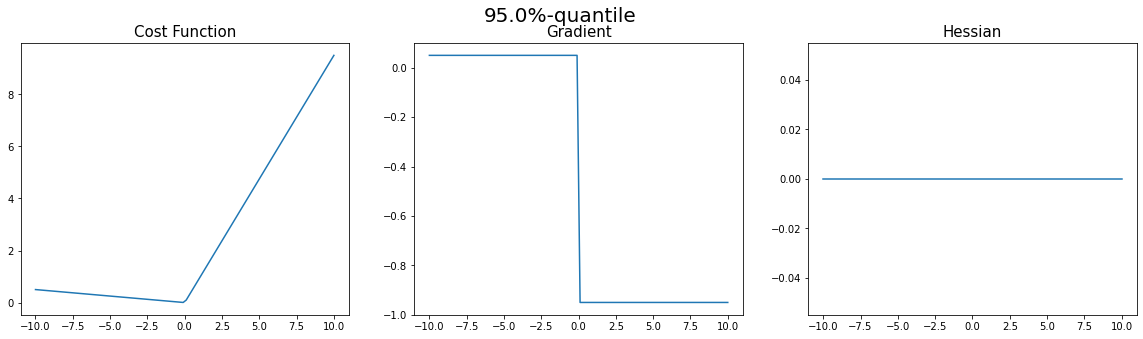

In [ ]:
#@title Quantile Cost Function
alpha = 0.95 #@param {type:"number"}
x = np.linspace(-10.,10.,100)
cost = XGBQuantile.quantile_cost(x, alpha)
'''
Plots of gradient, hessian and cost function for quantile regression
'''
fig = plt.figure(figsize=(20,5))

plt.suptitle('{alpha:0.1%}-quantile'.format(alpha=alpha),size=20)
plt.subplot(1,3,1)
plt.plot(x,cost)
_ = plt.title('Cost Function',size=15)

grad,hess = XGBQuantile.original_quantile_loss(x, 
                                      np.zeros(len(x)),
                                      alpha=alpha,
                                      delta=0.01)

plt.subplot(1,3,2)
plt.plot(x,grad)
_ = plt.title('Gradient',size=15)

plt.subplot(1,3,3)
plt.plot(x,hess)
_ = plt.title('Hessian',size=15)

Unfortunately, the mechanism of xgboost does not do well with Gradients and Hessians which are **constant over large intervals**.

Briefly explain, recall that XGBoost attempts to build a new tree at every iteration by improving on the prediction generated by the other trees.

When constructing the new tree, the algorithm spreads data over different nodes of the tree.  Let us say, we have a partition of data within a node. This node is only split if it decreases the cost function. The split condition is given below:



$$\mathcal{L}_{\mbox{ split}} = \frac{\left(\sum\limits_{i \in I_L}g_j \right)^2}{\sum\limits_{i \in I_L}h_j+\lambda}+\frac{\left(\sum\limits_{i \in I_R}g_j\right)^2}{\sum\limits_{i \in I_R}h_j+\lambda}-\frac{\left(\sum\limits_{i \in I}g_j\right)^2}{\sum\limits_{i \in I}h_j+\lambda}~~~~\mbox{for } I_{L} \cup I_{R} = I $$



Have a look at the visualisation below. 

Feel free to shift around the values around in the partition by varying  **partition_min** and **partition_max**.

Recall that points near **origin** mean that for these points the algorithms is already estimating very well the quantile. As we rarely have such an accurate estimate before boosting, each datapoint are **concentrated far from the origin**. Due to the lack of variation in the gradient and hessian in these regions, the split_gain will generally be zero. Therefore, the node of the tree will not be split. And this is why, XGBoost does not work with cost function with constant gradients/hessians.



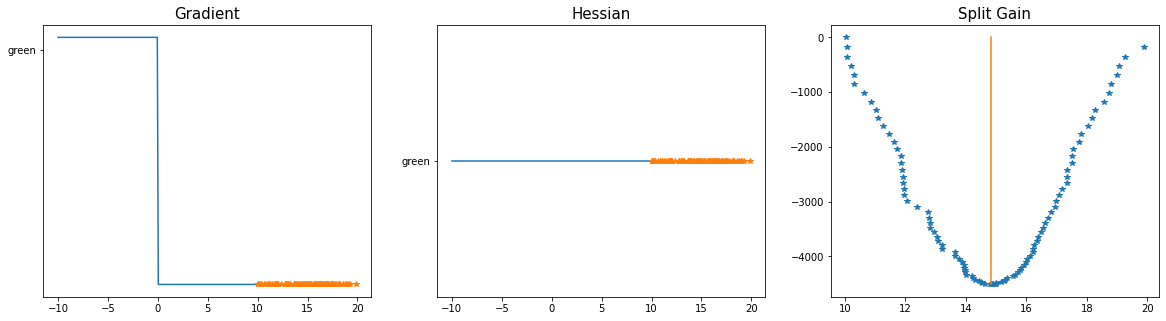

In [ ]:
x_min = -10.
x_max = 10.

assert(x_min < x_max),"Please assign x_min < x_max"
alpha = 0.95 #@param {type:"number"}
partition_min =  10#@param {type:"number"}
partition_max = 20 #@param {type:"number"}
data_volume = 100  #@param {type:"number"} #making this half volume to avoid unnecessary issues

VOLUME = data_volume*2
x = np.linspace(x_min,x_max,VOLUME)

x_sample = np.sort((partition_max-partition_min)*np.random.rand(VOLUME//2,)+ partition_min)
grad,hess = XGBQuantile.original_quantile_loss(x, 
                                      np.zeros(len(x)),
                                      alpha=alpha,
                                      delta=0.01)

grad_sample,hess_sample = XGBQuantile.original_quantile_loss(x_sample, 
                                      np.zeros(len(x_sample)),
                                      alpha=alpha,
                                      delta=0.01)
split_gain = XGBQuantile.get_split_gain(grad_sample,hess_sample,l=1.0)

fig = plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,grad)
plt.plot(x_sample,grad_sample,'*','green')
_ = plt.title('Gradient',size=15)

plt.subplot(1,3,2)
plt.plot(x,hess)
_ = plt.title('Hessian',size=15)
plt.plot(x_sample,hess_sample,'*','green')

plt.subplot(1,3,3)
_ = plt.title('Split Gain',size=15)
_ = plt.plot(x_sample,split_gain,'*')
plt.plot(np.ones((VOLUME//2,))*np.median(x_sample),np.linspace(np.min(split_gain),0,VOLUME//2))

Now, we now the current gradient and hessian of the cost function of quantile regression is incompatible with the vanilla xgboost algorithm, what can we do about it?

Ideally, we wish the following:



*   if points are far from the origin,i.e. the difference between the true quantile and its estimate, we wish to reshuffle our estimate.  We can force a randomsplit by randomizing the gradient and making the hessian constant.
*   if points close enough to the true quantile, we wish to bring them closer by smoothing a small region around the origin

These is precisely what the hyperparameters below are achieving:



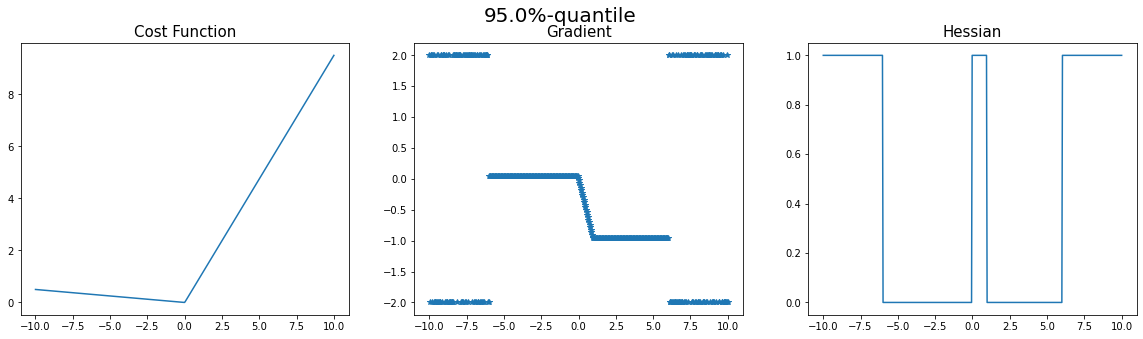

In [ ]:
#@title Modified Gradients - Hessian
alpha = 0.95 #@param {type:"number"}
threshold = 6 #@param {type:"number"}
delta = 1.0 #@param {type:"number"}
variance = 2. #@param {type:"number"}
x = np.linspace(-10.,10.,500)

cost = XGBQuantile.quantile_cost(x, alpha)
'''
Plots of gradient, hessian and cost function for quantile regression
'''
fig = plt.figure(figsize=(20,5))

plt.suptitle('{alpha:0.1%}-quantile'.format(alpha=alpha),size=20)
plt.subplot(1,3,1)
plt.plot(x,cost)
_ = plt.title('Cost Function',size=15)

grad,hess = XGBQuantile.quantile_loss(x, 
                                      np.zeros(len(x)),
                                      alpha=alpha,
                                      delta=delta,
                                      threshold=threshold,
                                      var=variance)

plt.subplot(1,3,2)
plt.plot(x,grad,'*')
_ = plt.title('Gradient',size=15)

plt.subplot(1,3,3)
plt.plot(x,hess)
_ = plt.title('Hessian',size=15)

Have a look at the visualisation below and feel free to shift around the values around in the partition by varying partition_min and partition_max .

Notice how we have created variation within the split condition

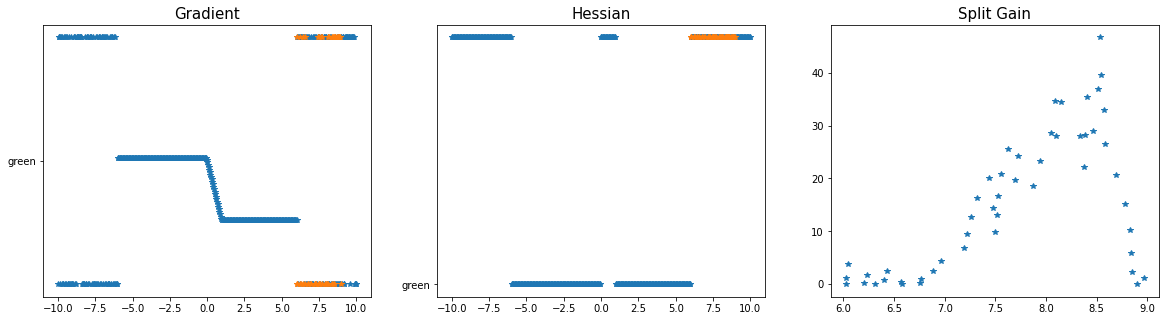

In [ ]:
#@title Modified Gradients - Hessian
alpha = 0.95 #@param {type:"number"}
threshold = 6 #@param {type:"number"}
delta = 1.0 #@param {type:"number"}
variance = 2. #@param {type:"number"}
partition_min = 6 #@param {type:"number"}
partition_max = 9 #@param {type:"number"}

x_sample = np.sort((partition_max-partition_min)*np.random.rand(50,)+ partition_min)
x = np.linspace(-10.,10.,500)

grad,hess = XGBQuantile.quantile_loss(x, 
                                      np.zeros(len(x)),
                                      alpha=alpha,
                                      delta=delta,
                                      threshold=threshold,
                                      var=variance)
grad_sample,hess_sample = XGBQuantile.quantile_loss(x_sample, 
                                      np.zeros(len(x_sample)),
                                      alpha=alpha,
                                      delta=delta,
                                      threshold=threshold,
                                      var=variance)

split_gain = XGBQuantile.get_split_gain(grad_sample,hess_sample,l=1.0)

fig = plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,grad,'*')
plt.plot(x_sample,grad_sample,'*','green')
_ = plt.title('Gradient',size=15)

plt.subplot(1,3,2)
plt.plot(x,hess,'*')
_ = plt.title('Hessian',size=15)
plt.plot(x_sample,hess_sample,'*','green')

plt.subplot(1,3,3)
plt.plot(x_sample,split_gain,'*')
_ = plt.title('Split Gain',size=15)

# 2.Sklearn Quantile Gradient Boosting versus XGBoost with Custom Loss

Gradient Boosting alpha = 0.05,score = 185.2
Gradient Boosting alpha = 0.95,score = 190.6
[14:00:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Quantile XGB alpha = 0.05,score = 175.2
Quantile XGB alpha = 0.95,score = 123.1


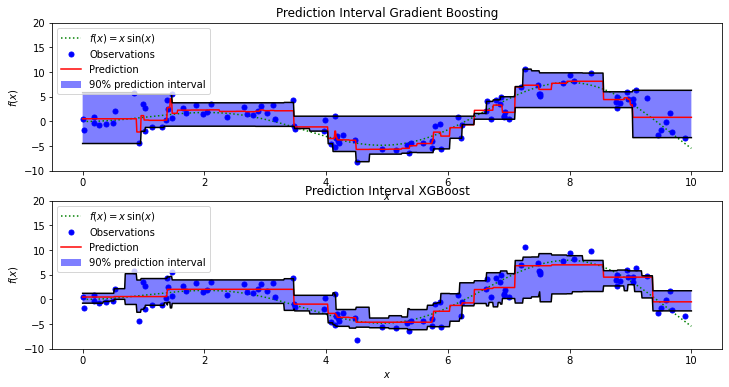

In [ ]:
alpha = 0.95 #@param {type:"number"}

X_train,y_train,X_test,y_test = generate_data()


regressor = GradientBoostingRegressor(n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)
y_pred = regressor.fit(X_train,y_train).predict(X_test)
regressor.set_params(loss='quantile', alpha=1.-alpha)
y_lower = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=1.-alpha,model_name="Gradient Boosting")
regressor.set_params(loss='quantile', alpha=alpha)
y_upper = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=alpha,model_name="Gradient Boosting")

                                                                 
fig = plt.figure(figsize=(12,6))

plt.subplot(211)
plt.title("Prediction Interval Gradient Boosting")
plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower)


regressor = XGBRegressor(n_estimators=250,max_depth=3,reg_alpha=5, reg_lambda=1,gamma=0.5)
y_pred = regressor.fit(X_train,y_train).predict(X_test)

regressor = XGBQuantile(n_estimators=100,max_depth = 3, reg_alpha =5.0,gamma = 0.5,reg_lambda =1.0 )     
regressor.set_params(quant_alpha=1.-alpha,quant_delta=1.0,quant_thres=5.0,quant_var=3.2)

y_lower = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=1.-alpha,model_name="Quantile XGB")
regressor.set_params(quant_alpha=alpha,quant_delta=1.0,quant_thres=6.0,quant_var = 4.2)
y_upper = collect_prediction(X_train,y_train,X_test,y_test,estimator=regressor,alpha=alpha,model_name="Quantile XGB")

plt.subplot(212)
plt.title("Prediction Interval XGBoost")
plot_result(X_train,y_train,X_test,y_test,y_upper,y_lower)


# Appendix -  Tuning the parameters

Feel free to play around with the code below if you wish to further tune the parameters

In [ ]:

X_train,y_train,_,_ = generate_data()

estimator = XGBQuantile(quant_alpha = 0.95,quant_delta= 5.0, quant_thres = 5.0 ,quant_var=4.0)

gs  = RandomizedSearchCV(estimator = estimator, 
                        param_distributions={
                                  'quant_delta':scipy.stats.uniform(0.01,10.0),
                                  'quant_var':scipy.stats.uniform(1.0,10.0),
                                  'quant_thres':scipy.stats.uniform(0.01,10.0)
                        },n_iter=200,cv=5,iid=True,return_train_score =False)

gs.fit(X_train,y_train)

print(
pd.DataFrame(gs.cv_results_).loc[:5,['mean_test_score','std_test_score','param_quant_delta','param_quant_thres','param_quant_var']]
)



   mean_test_score  std_test_score  ... param_quant_thres param_quant_var
0         0.115687        0.067952  ...           8.52672         5.15849
1         0.035480        0.016652  ...           2.34666         2.01967
2         0.090852        0.064269  ...           4.78141         2.52672
3         0.077254        0.012327  ...            5.4501         7.54137
4         0.133829        0.055607  ...           7.52528         3.22049
5         0.139670        0.082391  ...           7.86296          1.2233

[6 rows x 5 columns]


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
